In [1]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer,OneHotEncoder,VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql import *
from pyspark.ml.evaluation import BinaryClassificationEvaluator as BCE
import pyspark.sql.functions as F
from pyspark.mllib.evaluation import MulticlassMetrics

from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
df = spark.read.csv('gs://dataproc-staging-us-central1-881288578123-co6sg2sg/clear_csv/*.csv',header=False)
df = df.toDF('MONTH','DAY_OF_WEEK','OP_UNIQUE_CARRIER','ORIGIN','DEST','DEP_DELAY_NEW','ARR_DELAY_NEW','DISTANCE','DEP_TIME','ARR_TIME')
df = df.where(df.DISTANCE != 'DISTANCE')
df = df.withColumn("DISTANCE",col("DISTANCE").cast(IntegerType()))

In [3]:
train_df, test_df = df.randomSplit([0.7, 0.3], seed=4298711)

In [4]:
indexers = [StringIndexer(inputCol="MONTH", outputCol="MONTH_index").setHandleInvalid("keep"), 
           StringIndexer(inputCol="DAY_OF_WEEK", outputCol="DAY_OF_WEEK_index").setHandleInvalid("keep"), 
           StringIndexer(inputCol="OP_UNIQUE_CARRIER", outputCol="OP_UNIQUE_CARRIER_index").setHandleInvalid("keep"), 
           StringIndexer(inputCol="ORIGIN", outputCol="ORIGIN_index").setHandleInvalid("keep"),
           StringIndexer(inputCol="DEST", outputCol="DEST_index").setHandleInvalid("keep"),
           StringIndexer(inputCol="DEP_DELAY_NEW", outputCol="DEP_DELAY_NEW_index").setHandleInvalid("keep"),
           StringIndexer(inputCol="ARR_DELAY_NEW", outputCol="label").setHandleInvalid("keep"),
           StringIndexer(inputCol="DEP_TIME", outputCol="DEP_TIME_index").setHandleInvalid("keep"),
           StringIndexer(inputCol="ARR_TIME", outputCol="ARR_TIME_index").setHandleInvalid("keep")
           ]

vectorAssembler = VectorAssembler(inputCols = ["MONTH_index", "DAY_OF_WEEK_index", "OP_UNIQUE_CARRIER_index","ORIGIN_index","DEST_index","DEP_DELAY_NEW_index","DEP_TIME_index","ARR_TIME_index"],outputCol = "features")

In [5]:
rf = RandomForestClassifier(labelCol = "label", featuresCol = "features",maxBins=382)
stages = indexers + [vectorAssembler,rf]

pipeline = Pipeline(stages=stages)
model = pipeline.fit(train_df)
fitted = model.transform(train_df)

In [8]:
predictions = model.transform(test_df)

In [11]:
predictionAndLabels = predictions.select("prediction","label").rdd
multi_metrics = MulticlassMetrics(predictionAndLabels)
precision_score = multi_metrics.weightedPrecision
recall_score = multi_metrics.weightedRecall
accuracy_score = multi_metrics.accuracy
f1_score = multi_metrics.weightedFMeasure()

In [12]:
# Some metrics on our classified datas

print("Accuracy Score   : "+str(accuracy_score)) # Accuracy shows the percentage of the correct classifications with respect to all the samples
print("Precision Score  : "+str(precision_score)) # Precision is the ratio of the correctly positive labeled to all positive labeled : TP/(TP+FP)
print("Recall Score     : "+str(recall_score)) # Recall (or Sensitivity) is the ratio of the correctly positive labeled to all who are positive in reality : TP/(TP+FN)
print("F1 Score         : "+str(f1_score)) # F1-score is the harmonic mean (average) of precision and recall : 2*(Recall * Precision) / (Recall + Precision)

Accuracy Score   : 0.8087299087348123
Precision Score  : 0.8088590085730363
Recall Score     : 0.8087299087348123
F1 Score         : 0.8087937452317515


In [13]:
preds_and_labels = predictions.select(['prediction','label']).withColumn('label', F.col('label').cast(FloatType())).orderBy('prediction')
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))

In [14]:
cf_matrix = metrics.confusionMatrix().toArray()

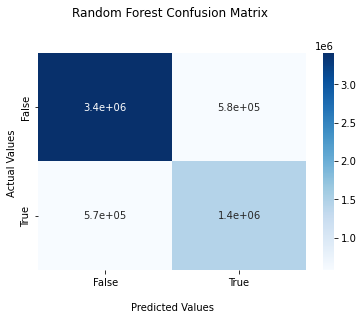

----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 53818)
Traceback (most recent call last):
  File "/opt/conda/miniconda3/lib/python3.8/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/opt/conda/miniconda3/lib/python3.8/socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "/opt/conda/miniconda3/lib/python3.8/socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/opt/conda/miniconda3/lib/python3.8/socketserver.py", line 747, in __init__
    self.handle()
  File "/usr/lib/spark/python/pyspark/accumulators.py", line 262, in handle
    poll(accum_updates)
  File "/usr/lib/spark/python/pyspark/accumulators.py", line 235, in poll
    if func():
  File "/usr/lib/spark/python/pyspark/accumulators.py", line 239, in accum_updates
    num_updates = read_int(self.rfile

In [15]:
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Random Forest Confusion Matrix \n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [18]:
predictions = model.transform(df)

In [21]:
clean_predictions= predictions.withColumn('delay',col('label'))
clean_predictions = predictions.drop("rawPrediction","label","ARR_DELAY_NEW","DISTANCE","MONTH","DAY_OF_WEEK","DEP_DELAY_NEW","MONTH_index", "DAY_OF_WEEK_index", "OP_UNIQUE_CARRIER_index","ORIGIN_index","DEST_index","DEP_DELAY_NEW_index","DEP_TIME_index","ARR_TIME_index","features")

In [22]:
clean_predictions = clean_predictions.distinct()

In [30]:
clean_predictions.show()

+------------------+------+----+---------+---------+--------------------+----------+
| OP_UNIQUE_CARRIER|ORIGIN|DEST| DEP_TIME| ARR_TIME|         probability|prediction|
+------------------+------+----+---------+---------+--------------------+----------+
|       Horizon Air|   BZN| SEA|  Morning|  Morning|[0.84953868170408...|       0.0|
|  Skywest Airlines|   RDM| PHX|  Morning|  Morning|[0.83685856119279...|       0.0|
| Republic Airlines|   DTW| PHL|  Evening|  Evening|[0.84942826881694...|       0.0|
|Southwest Airlines|   LAX| MDW|Afternoon|  Evening|[0.31744074677875...|       1.0|
|   United Airlines|   OMA| ORD|    Night|  Morning|[0.31926805685156...|       1.0|
| American Airlines|   DFW| BOS|  Evening|  Evening|[0.85531915945682...|       0.0|
|     Mesa Airlines|   DFW| JAN|  Evening|  Evening|[0.83423011510055...|       0.0|
|    Delta Airlines|   ATL| SEA|Afternoon|Afternoon|[0.85156492190202...|       0.0|
| American Airlines|   BOS| ORD|Afternoon|Afternoon|[0.8318603983

In [23]:
clean_predictions = clean_predictions.withColumn("probability",col("probability").cast(StringType()))

In [24]:
clean_predictions.write.option('header', True).mode('Overwrite').csv('gs://dataproc-staging-us-central1-881288578123-co6sg2sg/prediction_csv')